# Oscillation
This notebook contains experiments comparing methods for detecting oscillations. Using historical data, we simulate the following real-time detection scenario: streams of voltage/current measurements are retrieved, and we need to decide in (near) real-time whether an oscillation is beginning to occur. 

In [1]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.preprocessing import *
from modules.io import *

#from modules.patterns import *
#from modules.statistics import *
#from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm
import seaborn
import pickle
from copy import deepcopy
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline
import lightgbm as lgb
plt.style.use('ggplot')
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import glob
import datetime
import math as mt
import scipy.linalg as sl
import scipy.optimize as opt
import time

#modules/os_utils
from os_utils import * 

## Load Data
We read all data from http://web.eecs.utk.edu/~kaisun/Oscillation/actualcases.html. We keep values of current and voltage. Columns with name ending with '.1' contain voltage measurements in KV. Columns with name ending with '.3' contain current measurements in AMP.

In [2]:
filenames = glob.glob('/data/data2/oscillations_data/*/*.csv')
filenames 

['/data/data2/oscillations_data/ISO-NE-case3/ISO-NE_case3.csv',
 '/data/data2/oscillations_data/ISO-NE-case1/ISO-NE_case1.csv',
 '/data/data2/oscillations_data/ISO-NE-case4/ISO-NE_case4.csv',
 '/data/data2/oscillations_data/ISO-NE-case5/ISO-NE_case5.csv',
 '/data/data2/oscillations_data/ISO-NE-case2/ISO-NE_case2.csv']

In [3]:
dfs = {}
dfs_filtered = {}
for filename in filenames: 
    df = pd.read_csv(filename)
    df.dataframeName = filename
    nRow, nCol = df.shape
    print(f'There are {nRow} rows and {nCol} columns')

    for cols in df.columns:
        if cols =='Time':
            continue;        
    df = df.drop(labels=[0,1,2], axis=0)
    df = df.astype(float)
    df.set_index('Time',inplace=True)
    df.index = pd.Timestamp(datetime.date.today()) + pd.TimedeltaIndex(df.index, unit='s')
    #keep voltage and current
    df = df[df.columns[df.columns.str.endswith(".1")].union(df.columns[df.columns.str.endswith(".3")])] 
    df = df.dropna(axis = 1)
    dfs[filename] = df
    #dfs_filtered[filename] = df.apply(butter_lowpass_filter, axis = 0, result_type = 'broadcast', args = (cutoff, fs, order))

There are 5403 rows and 176 columns
There are 5403 rows and 176 columns
There are 9003 rows and 176 columns
There are 7203 rows and 176 columns
There are 10803 rows and 176 columns


Show one arbitrary dataframe.

In [4]:
dfs['/data/data2/oscillations_data/ISO-NE-case3/ISO-NE_case3.csv'].head()

,Sub:10:Ln:22.1,Sub:10:Ln:22.3,Sub:10:Ln:23.1,Sub:10:Ln:23.3,Sub:10:Ln:24.1,Sub:10:Ln:24.3,Sub:11:Ln:1-11.1,Sub:11:Ln:1-11.3,Sub:11:Ln:25.1,Sub:11:Ln:25.3,...,Sub:8:Ln:17.1,Sub:8:Ln:17.3,Sub:8:Ln:18.1,Sub:8:Ln:18.3,Sub:8:Ln:19.1,Sub:8:Ln:19.3,Sub:9:Ln:20.1,Sub:9:Ln:20.3,Sub:9:Ln:21.1,Sub:9:Ln:21.3
Time,,,,,,,,,,,,,,,,,,,,,
2023-03-14 00:00:00.000,206.2200,971.3879,206.2705,1518.8809,206.2200,284.7329,205.2894,96.5042,205.3076,242.7212,...,204.8760,559.6404,205.0022,53.3708,205.0022,55.8035,206.6733,388.7487,206.1485,415.6480
2023-03-14 00:00:00.033,206.2137,972.3035,206.2642,1518.8809,206.2137,284.7329,205.2890,96.5042,205.2964,243.2891,...,204.8770,559.4954,205.0034,53.3708,205.0034,55.8901,206.6851,389.0436,206.1581,416.0374
2023-03-14 00:00:00.067,206.2073,971.3879,206.2579,1518.8809,206.2073,284.7329,205.2783,96.7206,205.2856,242.9704,...,204.8687,559.3512,204.9950,53.9152,204.9950,55.8901,206.6608,389.1947,206.1517,416.2412
2023-03-14 00:00:00.100,206.2010,972.3035,206.2579,1518.8809,206.2010,284.7329,205.2787,96.7206,205.2944,242.9373,...,204.8705,559.4602,205.0066,54.0589,205.0066,55.9799,206.6804,389.2089,206.1538,416.4459
2023-03-14 00:00:00.133,206.2137,972.3035,206.2705,1518.8809,206.2137,283.8174,205.2794,96.3528,205.3057,242.6197,...,204.8726,559.1210,205.0087,53.6573,205.0087,55.5626,206.6752,388.9341,206.1605,416.2795


Select one column which will be used later in our experiments.

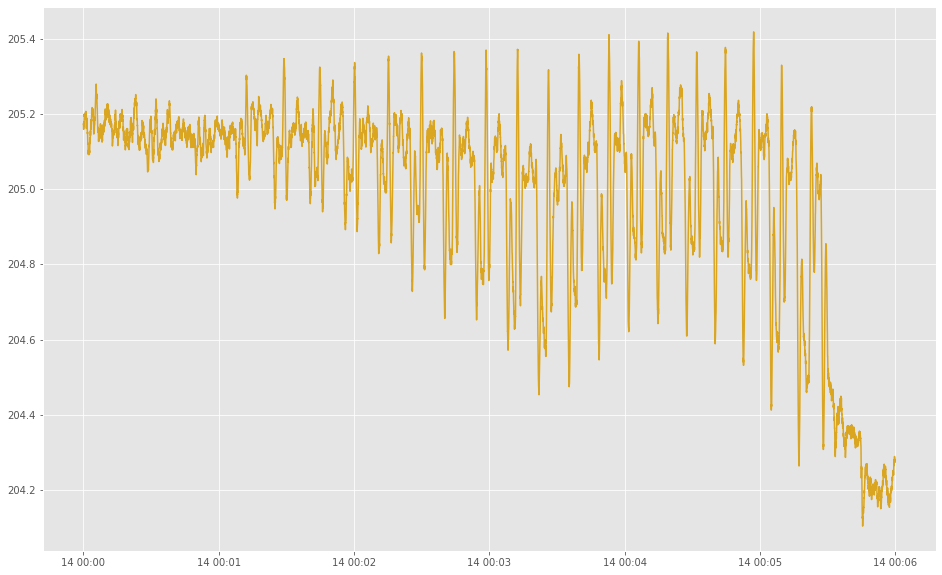

In [5]:
df_t = dfs['/data/data2/oscillations_data/ISO-NE-case2/ISO-NE_case2.csv']['Sub:11:Ln:1-11.1']
df_ts =  [dfs[f'/data/data2/oscillations_data/ISO-NE-case{i}/ISO-NE_case{i}.csv']['Sub:11:Ln:1-11.1'] for i in range(1,3)]
fig, ax1 = plt.subplots(figsize=(16, 10))
ax1.plot(df_t, color = 'goldenrod')

## Experiments

We now focus on one particular case. For the column of interest, we apply a rolling window, where we compute an indicator of dissimilarity between the segment of the signal lying within, and a sinusoidal approximation. We investigate four different ways of approximating the signal. 

We employ the prony method, the matrix-pencil method, a non-linear least squares regression of a sinusoidal function, and an approach which is solely based on FFT for approximating the underlying sinusoid. The idea is that when an oscillation occurs, the signal behaves like a sinusoid. Hence, by estimating the error of a tightly fitted sinusoidal function, we have a measure of how likely it is for a segment of the input signal to contain an oscillation.  

To decide whether to raise an alarm (meaning that there is an oscilation starting), we compare the last 10 seconds with the whole stream seen so far. If the fitting error is unusually small and the amplitude is unusually large, we decide that the there is an oscillation starting within the last 10 seconds.  

In [6]:
#number of stds defining an anomaly on the MSE error between the actual signal and its approximation.
a = 2
#number of stds defining an anomaly on amplitude
b = 0

### Alerting based on the prony method

In [7]:
errors_prony_list = []
alerts_prony_list = []
start = time.time()
n_prony = 0
for df_t in df_ts:
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    j = min(df_t.index)+pd.Timedelta(seconds=10)
    errors_prony = []
    alerts_prony = []
    for j in tqdm(new_index):
        n_prony = n_prony + 1
        #new data retrieved every 1s
        #decision made on data from the last 10s
        y = df_t[j-pd.Timedelta(seconds=10):j]
        if len(df_t[j-pd.Timedelta(seconds=10):j])%2 != 0:
            y = y[1:]
            
        var = np.var(y)
        y_norm = (y - np.mean(y))/var

        # Approximate the signal using the prony method
        approx_signal1, _ = prony_method(y_norm, int(len(y_norm)/60)) 
        try:
            errors_prony.append(mse(y_norm, approx_signal1, squared=False))
        except: 
            errors_prony.append(np.nan)
        alerts_prony.append(int(errors_prony[-1] < np.nanmean(errors_prony)-a*np.nanstd(errors_prony))*int(np.abs(y[-1]-np.mean(y[:-1]))>b*np.std(y[:-1])))
    
    errors_prony_list.append(errors_prony)
    alerts_prony_list.append(alerts_prony)
    
end = time.time()

#total running time:
total_running_time_prony = datetime.timedelta(seconds=end-start)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

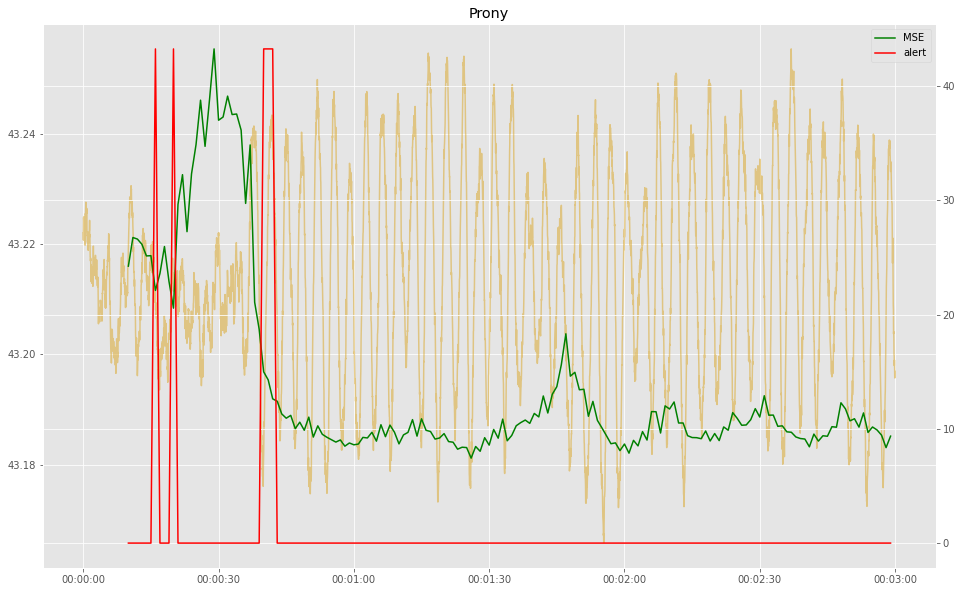

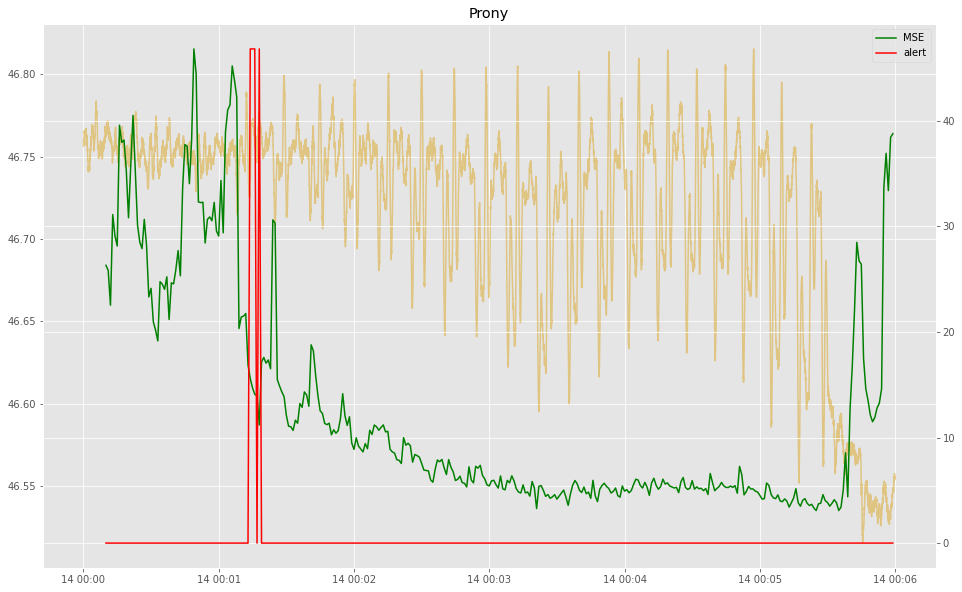

In [8]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_prony_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(errors_prony_list[i]), index = new_index),color = 'green', label = 'MSE')
    ax2.plot(pd.Series(np.array(alerts_prony_list[i])*np.nanmax(errors_prony_list[i]), index = new_index),color = 'red', label = 'alert')
    ax2.title.set_text('Prony')
    ax2.legend()

### Alerting based on the Matrix-Pencil method

In [9]:

errors_mp_list = []
alerts_mp_list = []
start = time.time()
n_mp = 0
for df_t in df_ts:
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    j = min(df_t.index)+pd.Timedelta(seconds=10)
    errors_mp = []
    alerts_mp = []
    for j in tqdm(new_index):
        n_mp = n_mp+1
        #new data retrieved every 1s
        #decision made on data from the last 10s
        y = df_t[j-pd.Timedelta(seconds=10):j]
        if len(df_t[j-pd.Timedelta(seconds=10):j])%2 != 0:
            y = y[1:]

        var = np.var(y)
        y_norm = (y - np.mean(y))/var

        # Approximate the signal using the matrix-pencil method
        approx_signal2 = MPM(y_norm, int(len(y_norm)/60)) 
        try:
            errors_mp.append(mse(y_norm, approx_signal2, squared=False))
        except:
            errors_mp.append(np.nan)
        alerts_mp.append(int(errors_mp[-1] < np.nanmean(errors_mp)-a*np.nanstd(errors_mp))*int(np.abs(y[-1]-np.mean(y[:-1]))>b*np.std(y[:-1])))    
    errors_mp_list.append(errors_mp)
    alerts_mp_list.append(alerts_mp)
end = time.time()

#total running time:
total_running_time_mp = datetime.timedelta(seconds=end-start)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

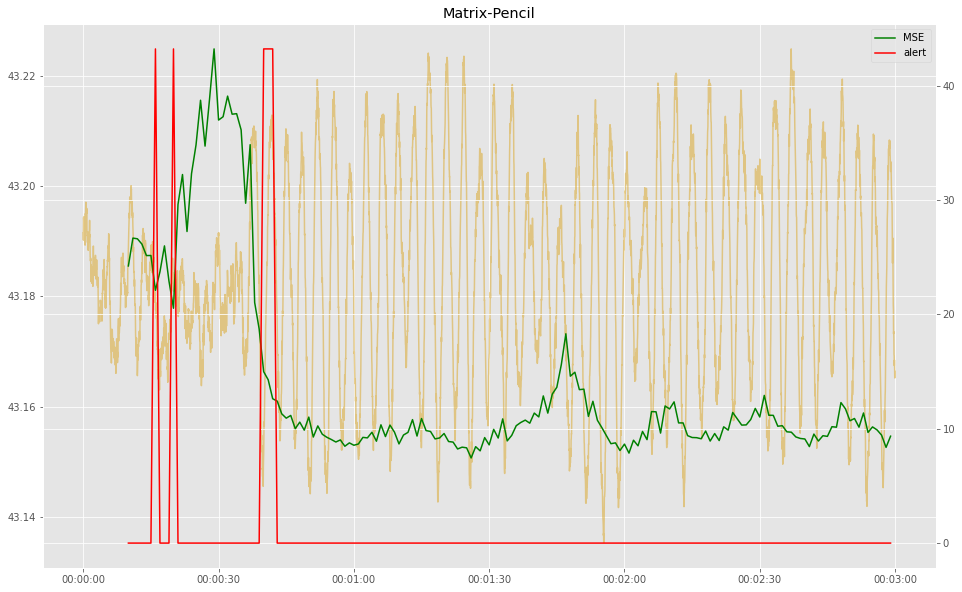

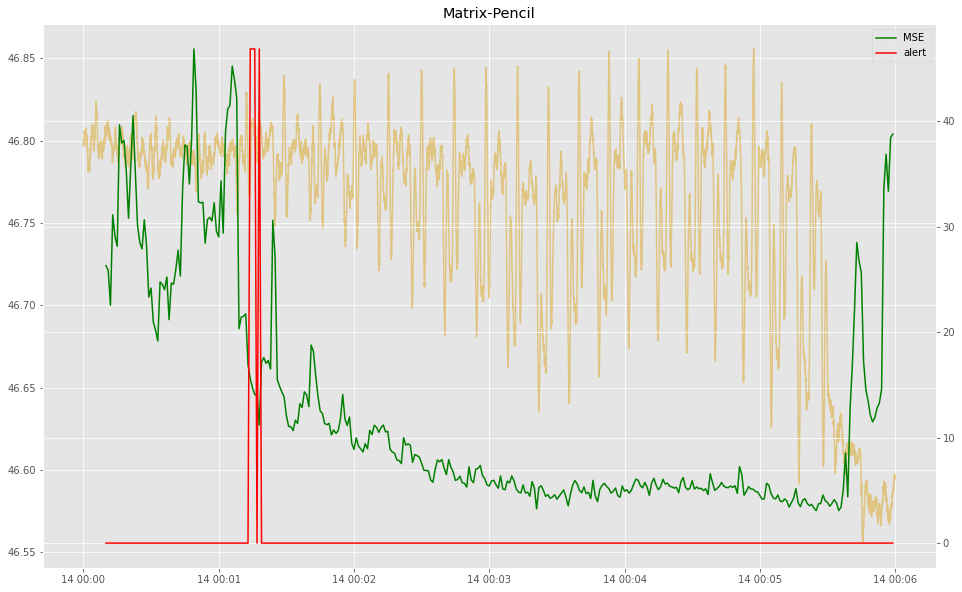

In [10]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_mp_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(errors_mp_list[i]), index = new_index),color = 'green', label = 'MSE')
    ax2.plot(pd.Series(np.array(alerts_mp_list[i])*np.nanmax(errors_mp_list[i]), index = new_index),color = 'red', label = 'alert')
    ax2.title.set_text('Matrix-Pencil')
    ax2.legend()

### Alerting based on non-linear LSM sinusoidal regression

In [11]:
start = time.time()

errors_sin_list = []
alerts_sin_list = []
n_sin=0
for df_t in df_ts:
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')

    j = min(df_t.index)+pd.Timedelta(seconds=10)
    errors_sin = []
    alerts_sin = []
    for j in tqdm(new_index):
        n_sin = n_sin+1
        #new data retrieved every 1s
        #decision made on data from the last 10s
        y = df_t[j-pd.Timedelta(seconds=10):j]
        if len(df_t[j-pd.Timedelta(seconds=10):j])%2 != 0:
            y = y[1:]

        var = np.var(y)
        y_norm = (y - np.mean(y))/var

        # Approximate the signal using sinusoidal regression
        approx_signal3, y_norm = fit_sin_lsm(y)
        try:
            errors_sin.append(mse(y_norm, approx_signal3, squared=False))
        except:
            errors_sin.append(np.nan)
        alerts_sin.append(int(errors_sin[-1] < np.nanmean(errors_sin)-a*np.nanstd(errors_sin))*int(np.abs(y[-1]-np.mean(y[:-1]))>b*np.std(y[:-1])))
    
    errors_sin_list.append(errors_sin)
    alerts_sin_list.append(alerts_sin)
end = time.time()

#total running time:
total_running_time_sin = datetime.timedelta(seconds=end-start)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

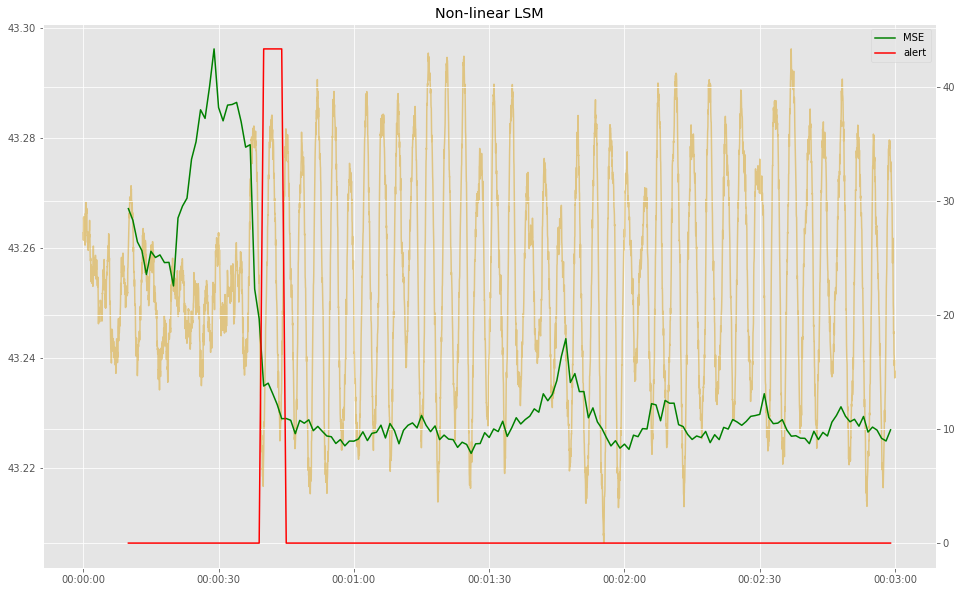

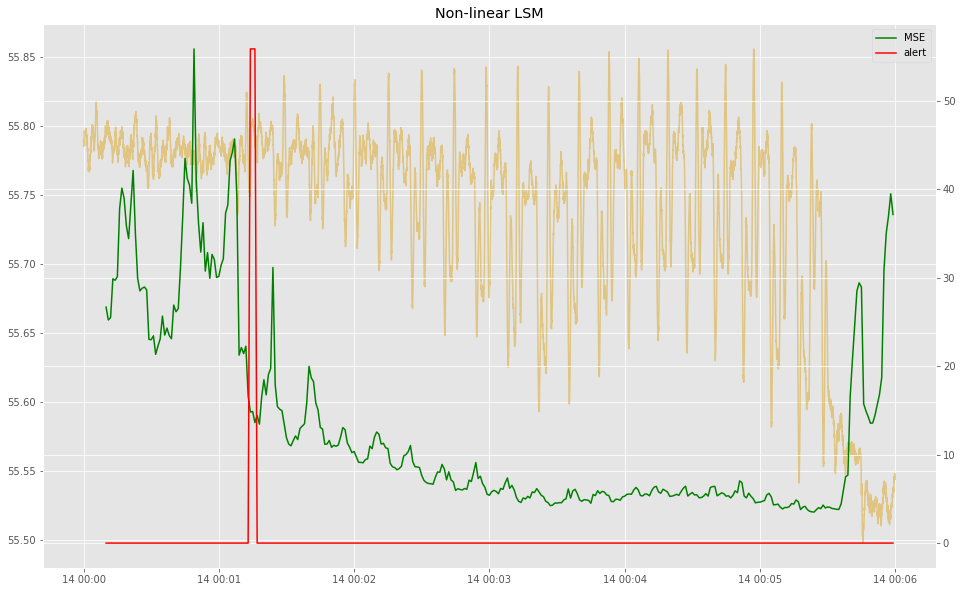

In [12]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_sin_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(errors_sin_list[i]), index = new_index),color = 'green', label = 'MSE')
    ax2.plot(pd.Series(np.array(alerts_sin_list[i])*np.nanmax(errors_sin_list[i]), index = new_index),color = 'red', label = 'alert')
    ax2.title.set_text('Non-linear LSM')
    ax2.legend()

### Alerting based on a FFT-based fitting of a sinusoidal

In [13]:
start = time.time()
errors_sin_simple_list = []
alerts_sin_simple_list = []
n_simple = 0
for df_t in df_ts:
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    j = min(df_t.index)+pd.Timedelta(seconds=10)
    errors_sin_simple = []
    alerts_sin_simple = []
    for j in tqdm(new_index):
        n_simple = n_simple+1
        #new data retrieved every 1s
        #decision made on data from the last 10s
        y = df_t[j-pd.Timedelta(seconds=10):j]
        if len(df_t[j-pd.Timedelta(seconds=10):j])%2 != 0:
            y = y[1:]

        var = np.var(y)
        y_norm = (y - np.mean(y))/var

        # Approximate the signal using sinusoidal regression
        approx_signal3, y_norm = fit_sin_simple(y)
        try:
            errors_sin_simple.append(mse(y_norm, approx_signal3, squared=False))
        except:
            errors_sin_simple.append(np.nan)
        alerts_sin_simple.append(int(errors_sin_simple[-1] < np.nanmean(errors_sin_simple)-a*np.nanstd(errors_sin_simple))*int(np.abs(y[-1]-np.mean(y[:-1]))>b*np.std(y[:-1])))
    errors_sin_simple_list.append(errors_sin_simple)
    alerts_sin_simple_list.append(alerts_sin_simple)
        
end = time.time()

#total running time:
total_running_time_sin_simple = datetime.timedelta(seconds=end-start)

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

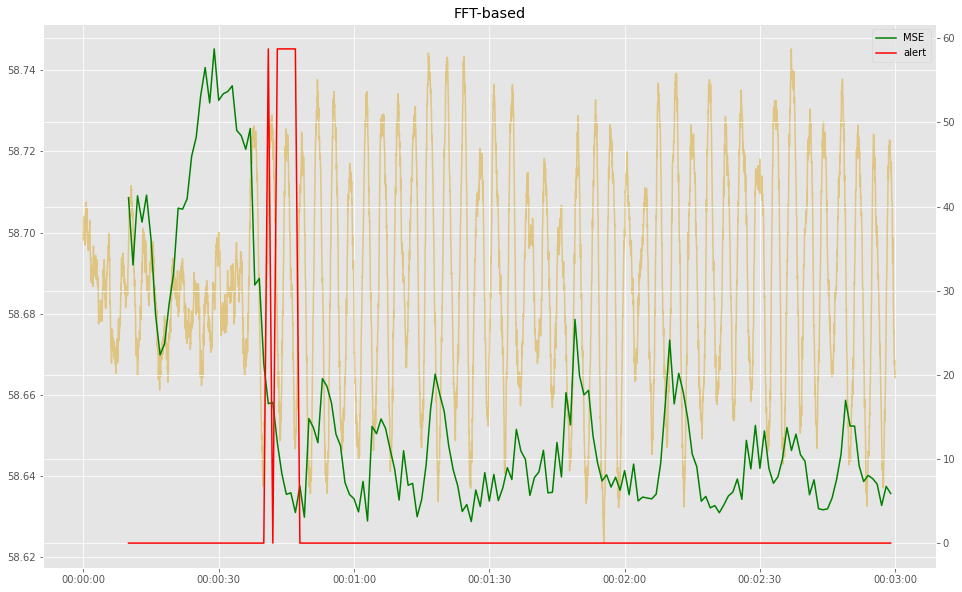

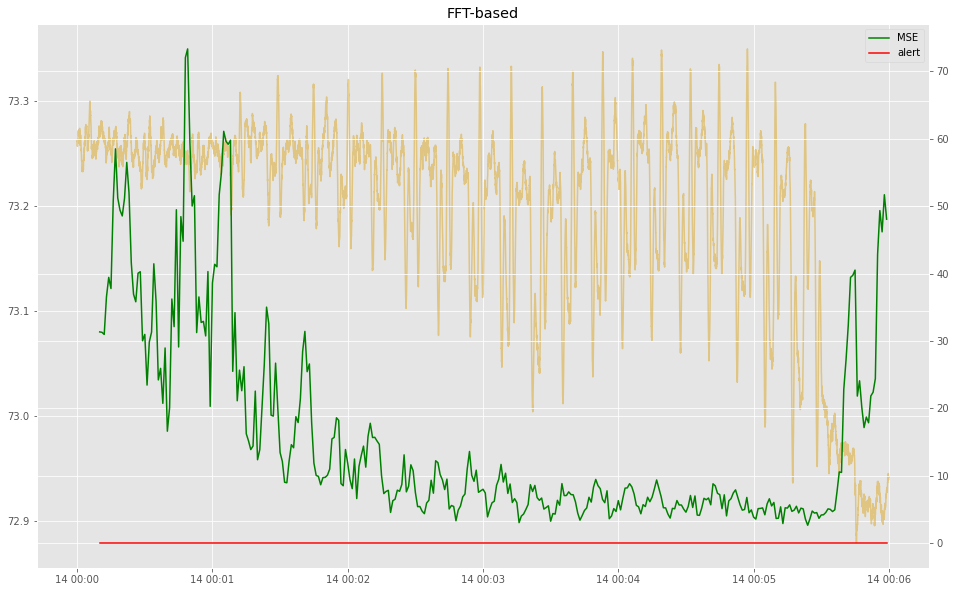

In [14]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_sin_simple_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(errors_sin_simple_list[i]), index = new_index),color = 'green', label = 'MSE')
    ax2.plot(pd.Series(np.array(alerts_sin_simple_list[i])*np.nanmax(errors_sin_simple_list[i]), index = new_index),color = 'red', label = 'alert')

    ax2.title.set_text('FFT-based')
    ax2.legend()

#### Plot all together
First plot mean squared errors between each signal approximation and the actual signal.

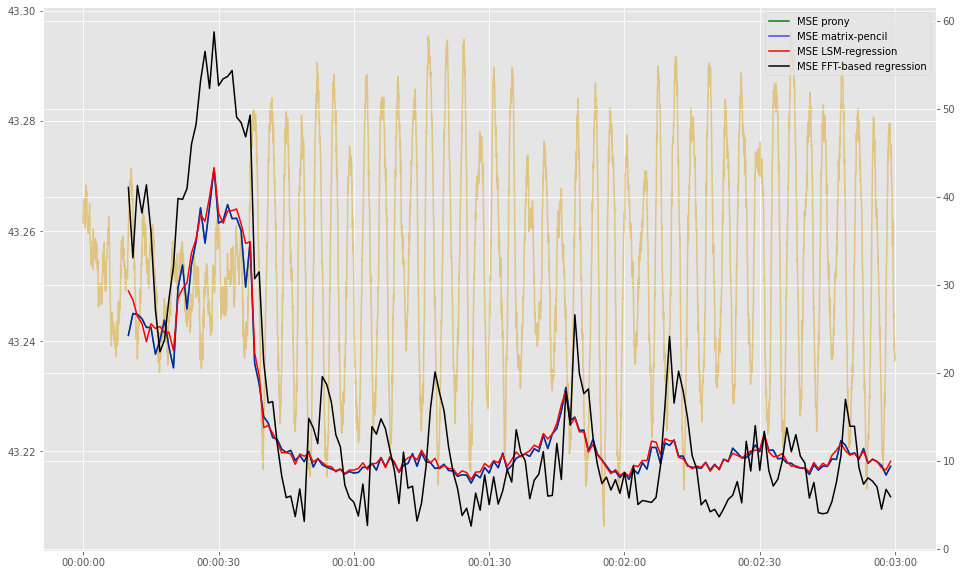

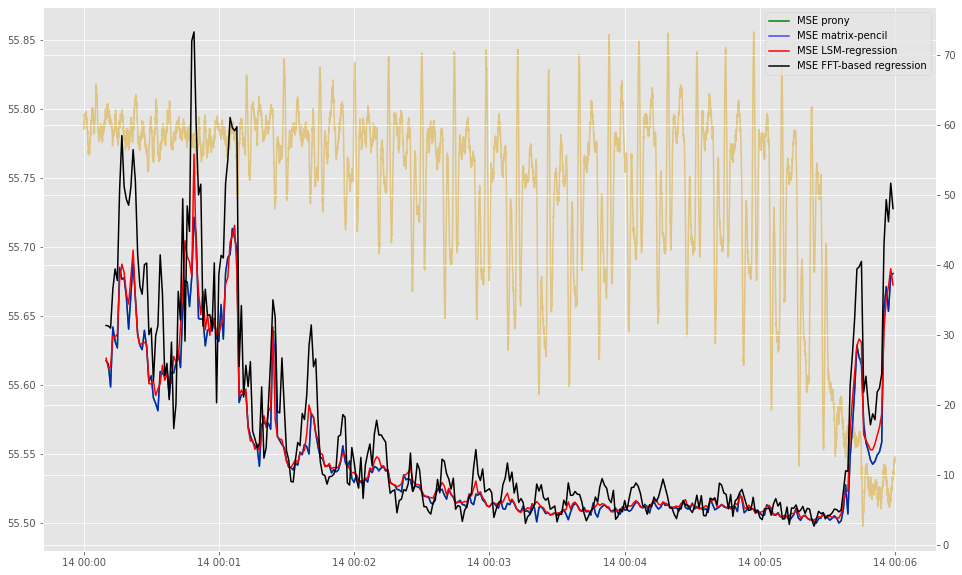

In [15]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_sin_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(errors_prony_list[i]), index = new_index),color = 'green', label = 'MSE prony')
    ax2.plot(pd.Series(np.array(errors_mp_list[i]), index = new_index),color = 'blue', label = 'MSE matrix-pencil', alpha = 0.7)
    ax2.plot(pd.Series(np.array(errors_sin_list[i]), index = new_index),color = 'red', label = 'MSE LSM-regression')
    ax2.plot(pd.Series(np.array(errors_sin_simple_list[i]), index = new_index),color = 'black', label = 'MSE FFT-based regression')
    ax2.title.set_text('')
    ax2.legend()

Then, plot alerts.

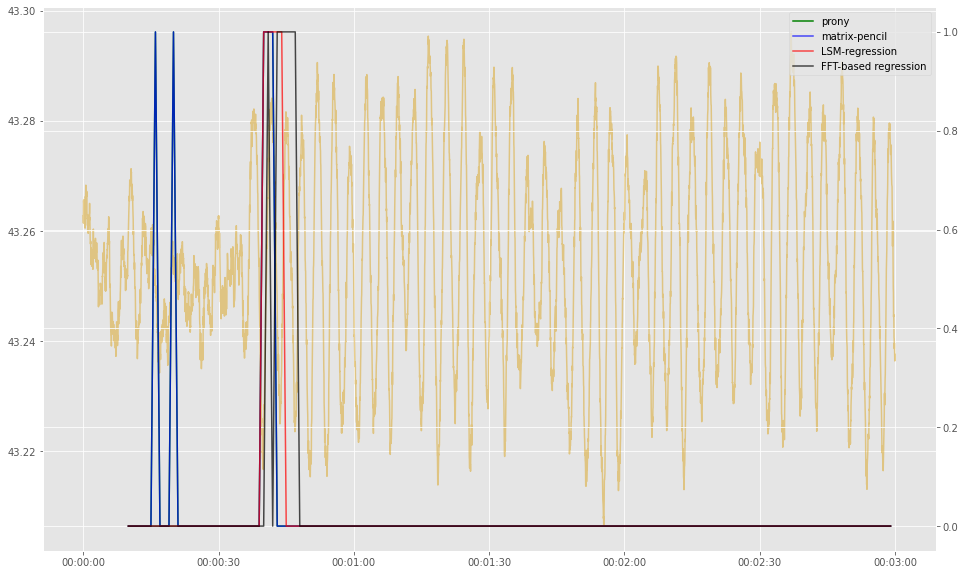

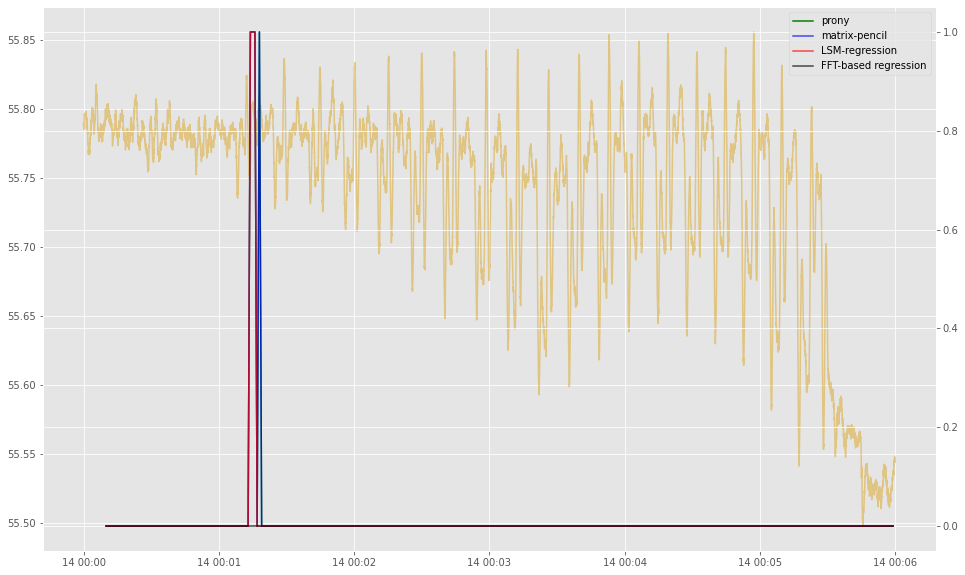

In [16]:
for i, df_t in enumerate(df_ts):
    new_index = pd.date_range(start=min(df_t.index)+pd.Timedelta(seconds=10), end=max(df_t.index), freq='1s')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(df_t*np.nanmax(errors_sin_list[i])/np.nanmax(df_t),color = 'goldenrod',alpha=0.5)
    ax2.plot(pd.Series(np.array(alerts_prony_list[i]), index = new_index),color = 'green', label = 'prony', alpha = 1)
    ax2.plot(pd.Series(np.array(alerts_mp_list[i]), index = new_index),color = 'blue', label = 'matrix-pencil', alpha = 0.7)
    ax2.plot(pd.Series(np.array(alerts_sin_list[i]), index = new_index),color = 'red', label = 'LSM-regression', alpha = 0.7)
    ax2.plot(pd.Series(np.array(alerts_sin_simple_list[i]), index = new_index),color = 'black', label = 'FFT-based regression', alpha = 0.7)

    #ax2.plot(pd.Series(np.array(alerts_sin), index = new_index),color = 'red', label = 'alert')
    ax2.title.set_text('')
    ax2.legend()

Total running time for the approach based on the prony method:

In [17]:
total_running_time_prony.total_seconds()

2.616509

Average running time for the approach based on the prony method:

In [18]:
total_running_time_prony.total_seconds()/n_prony

0.005031748076923077

Total running time for the approach based on the matrix-pencil method:

In [19]:
total_running_time_mp.total_seconds()

1.700029

Average running time for the approach based on the matrix-pencil method:

In [20]:
total_running_time_mp.total_seconds()/n_mp

0.0032692865384615385

Total running time for the approach based on the LSM regression:

In [21]:
total_running_time_sin.total_seconds()

5.502425

Average running time for the approach based on the LSM regression:

In [22]:
total_running_time_sin.total_seconds()/n_sin

0.010581586538461538

Total running time for the approach based on FFT:

In [23]:
total_running_time_sin_simple.total_seconds()

1.01001

Total running time for the approach based on FFT:

In [24]:
total_running_time_sin_simple.total_seconds()/n_simple

0.0019423269230769231